# Part 2 - TASK 5D

# Object Tracking Using Custom Vision

In [ ]:
#!pip install azure-cognitiveservices-vision-customvision
#!pip install azure-cognitiveservices-vision-customvision opencv-python pillow matplotlib
#!pip install azure-cognitiveservices-vision-customvision
#!pip install opencv-python
#!pip install pillow


## Import Libraries

In [ ]:
import cv2                                                                                      # OpenCV Library for image and video processing used for frame extraction and video creation
import os                                                                                       # provide functions to interact with operating system like creating folders, etc
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient # Connects to Azure's custom vision service to make predictions on images
from msrest.authentication import ApiKeyCredentials                                             # Authenticates requests to Azure using prediction key
from PIL import Image, ImageDraw, ImageFont                                                     # From pillow used to open images, draw bounding boxes and labels
import matplotlib.pyplot as plt                                                                 # Used for plotting images and visualising trajectories or annotated results
from collections import defaultdict                                                             # from Collections library, automatises the initialisation of lists to store coordinate points for each object tag

## Step 1: Extract frames from input video

In [ ]:
video_path = "objecttracking.mp4"
extracted_frame_dir = "extracted_frames"
os.makedirs(extracted_frame_dir, exist_ok=True)

# start of capturing frames using cv2
cap = cv2.VideoCapture(video_path)
frame_interval = 2                                                         # Extract every 2nd frame
frame_id = 0                                                               # Is actually frame number which is extracted
saved = 0

while cap.isOpened():                                                      # Checks if the video is really opened by cv2.VideoCapture(). If True loop proceeds
    ret, frame = cap.read()                                                # Reads a frame from video
    if not ret:                                                            # ret is return value, If not True: or if "false" then it breaks meaning no image captured
        break
    if frame_id % frame_interval == 0:                                     # This will run if above If not ret: does not run and that happens when image is read.
        filename = os.path.join(extracted_frame_dir, f"frame_{saved}.jpg") # Creates a file path using os.path.join() which is cross compatible function
        cv2.imwrite(filename, frame)                                       # This writes the frame captured into the file path derived from above line
        saved += 1                                                         # it is counter for how many frames are saved so far. So in first loop it is 1
    frame_id += 1                                                          # This is acting like a counter that is used to compare with frame_interval set and take a decision to capture the image further or not.

cap.release()                                                              # This actually closes the file opened above in cap.VideoCapture() line
print(f"Extracted {saved} frames into the directory '{extracted_frame_dir}/'")


Extracted 90 frames into the directory 'extracted_frames/'


## Step 2: Connect to Azure Custom Vision

In [ ]:
PREDICTION_KEY = "your-key-here"
PREDICTION_ENDPOINT = "your-endpoint-here"
PROJECT_ID = "your-projectid-here"
PUBLISHED_NAME = "kbcvobjtrack3"

credentials = ApiKeyCredentials(in_headers={"Prediction-Key": PREDICTION_KEY})
predictor = CustomVisionPredictionClient(PREDICTION_ENDPOINT, credentials)

## Step3: Predict and annotate bounding boxes

In [ ]:
font = ImageFont.load_default()                                                    # It loads a basic, built-in font from the PIL (Python Imaging Library) module so that text can be drawn on images using ImageDraw
trajectories = defaultdict(list)                                                   # Creates a dictionary where each key (object tag like "Person" say) starts with an empty list

for img_name in sorted(os.listdir(extracted_frame_dir)):                           # Loops through each image from the extracted_frame_dir after sorting those images
    img_path = os.path.join(extracted_frame_dir, img_name)                         # img_path gets the file path
    with open(img_path, "rb") as image_data:                                       # this file is opened in read binary format and aliased as image_data
        results = predictor.detect_image(PROJECT_ID, PUBLISHED_NAME, image_data)   # Sends the image to Azure Custom Vision and gets predicted bounding boxes for objects in the frame

# Example of what is contained in results object
#{
#  "tag_name": "Car",
#  "probability": 0.85,
#  "bounding_box": {
#    "left": 0.23,
#    "top": 0.40,
#    "width": 0.15,
#    "height": 0.10
#  }
#}


    image = Image.open(img_path).convert("RGB")                                    # One Image is opened and is converted into full colour so that further ImageDraw can work on it or becomes compatible to draw on it.
    draw = ImageDraw.Draw(image)                                                   # This line readies to draw on the image
    width, height = image.size                                                     # For the image that is opened - its width and height is recorded

    for prediction in results.predictions:                                         # Loop through predictions and convert normalized bounding box coordinates received from Azure custom vision to actual pixel values
        if prediction.probability * 100 >= 50:                                     # Only images with confidence score or probability greater than or equal to 50 are considered

# Below line of codes denormalises the values received from azure custom vision api by multiplying with actual width and height of the image
            left = prediction.bounding_box.left * width
            top = prediction.bounding_box.top * height
            w = prediction.bounding_box.width * width
            h = prediction.bounding_box.height * height
            center_x = left + w / 2                                                # This 2 line of code stores the center point across width and height axis
            center_y = top + h / 2

            tag = prediction.tag_name
            trajectories[tag].append((center_x, center_y))                         # Stores the center points calculated above in the trajectories list wherein key value is tag

            draw.rectangle([left, top, left + w, top + h], outline="red", width=3)  # Draws a rectangle with red colour on the image that fits on the object detected with name as in the object tag
            draw.text((left, top - 10), f"{tag} ({prediction.probability * 100:.1f}%)", fill="red", font=font)  # writes or draws the object name and confidence level above the bounding box

    image.save(img_path)                                                           # replaces the annotated image/frame with bounding boxes and object name, confidence level and replaces the unannotated image that was written by cv2.Imwrite()

## Step4: Recreate Video From Annotated Frames

In [ ]:
frame_files = sorted([f for f in os.listdir(extracted_frame_dir) if f.endswith(".jpg")])     # Gets a sorted list of all .jpg frame file names in the extracted_frame_dir folder.
first_frame = cv2.imread(os.path.join(extracted_frame_dir, frame_files[0]))                  # Reads the first image (to get frame size) using OpenCV
h, w, _ = first_frame.shape                                                                  # Extracts height (h) and width (w) of the first image to use for video size
video_out_path = "tracked_output.mp4"                                                        # Sets the output filename for the final annotated video.
video = cv2.VideoWriter(video_out_path, cv2.VideoWriter_fourcc(*"mp4v"), 5, (w, h))          # Initializes the video writer with output path, codec "mp4v", frame rate 5 FPS, and frame size (w, h).

for frame_file in frame_files:                                                               # Iterates over each annotated frame in frame_files object
    frame = cv2.imread(os.path.join(extracted_frame_dir, frame_file))                        # Reads the frame image from disk using OpenCV.
    video.write(frame)                                                                       # Writes the frame into video file in sequence
video.release()                                                                              # Closes and finalises the video file

print("\n Object tracking video saved as:", video_out_path)                                  # Prints a confirmation message with video file name


 Object tracking video saved as: tracked_output.mp4


## Step 5: Plot Object Trajectories

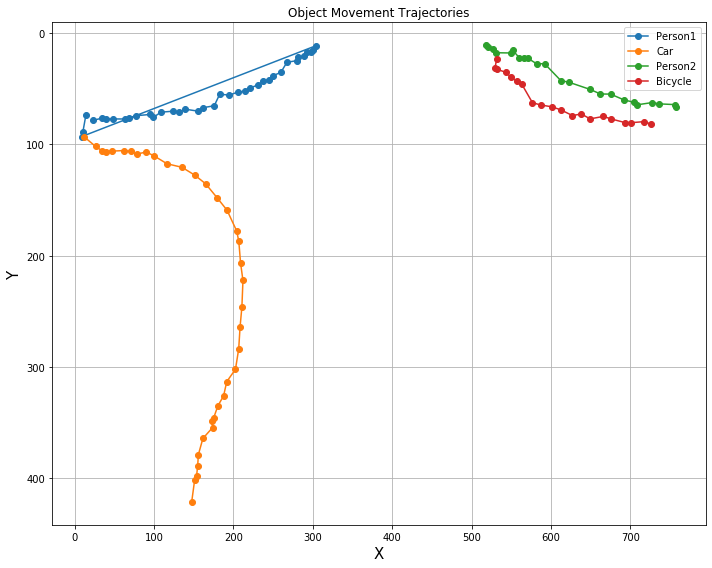

In [ ]:
plt.figure(figsize=(10, 8))
for tag, points in trajectories.items():              # Loops through each object tag (like "Person", "Car", etc.) and its list of (x, y) trajectory points that were collected from all frames
    xs, ys = zip(*points)                             # Splits the list of coordinate pairs into separate xs and ys lists — so you can plot x-positions against y-positions
    plt.plot(xs, ys, marker='o', label=tag)           # Plots the trajectory line with markers (o) for that object, and adds a label for the legend.

plt.gca().invert_yaxis()                              # Inverts the y-axis so that the top of the image becomes y=0, matching the image coordinate system (OpenCV and PIL use top-left as origin)
plt.title("Object Movement Trajectories")
plt.xlabel("X", fontsize = 15)
plt.ylabel("Y", fontsize = 15)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 6: Save Trajectory Data Into CSV File

In [ ]:
import csv

with open("object_trajectories.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Object", "Frame", "X", "Y"])

    for tag, points in trajectories.items():
        for frame_idx, (x, y) in enumerate(points):
            writer.writerow([tag, frame_idx, round(x, 2), round(y, 2)])

print("Trajectory data saved to 'object_trajectories.csv'")


Trajectory data saved to 'object_trajectories.csv'
